## 00. Imports

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

## 01. Loading MEFAR PreProcessed DataSet

In [70]:
MEFAR_DOWN = pd.read_csv('../raw_data//MEFAR_preprocessed/MEFAR_DOWN.csv')
MEFAR_MID = pd.read_csv('../raw_data//MEFAR_preprocessed/MEFAR_MID.csv')
MEFAR_UP = pd.read_csv('../raw_data//MEFAR_preprocessed/MEFAR_UP.csv')

((27570, 18), (923298, 18), (1846590, 18))

## 02. Data Exploration & Visualization

In [21]:
MEFAR_DOWN.head()

,BVP,EDA,TEMP,AccX,AccY,AccZ,HR,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,Attention,Meditation,class
0,0.009990,-0.023451,0.778824,-0.145540,-0.127273,0.371179,0.352246,0.019138,0.082949,0.017362,0.020516,0.001465,0.002844,0.021253,0.044376,0.484848,0.090909,1.0
1,0.007775,-0.050473,0.778824,-0.145540,-0.127273,0.379913,0.357959,0.016627,0.018269,0.000885,0.007088,0.009263,0.005343,0.001643,0.008448,0.040404,0.444444,1.0
2,-0.070514,-0.069910,0.778824,-0.136150,-0.100000,0.388646,0.363152,0.042245,0.000499,0.000753,0.000366,0.268484,0.002063,0.068640,0.001032,0.010101,0.545455,1.0
3,0.028787,-0.068803,0.781176,-0.333333,-0.072727,-0.406114,0.368476,0.047853,0.005451,0.094100,0.001209,0.009866,0.085111,0.560372,0.036195,0.464646,0.888889,1.0
4,-0.097677,-0.118167,0.774118,-0.333333,-0.109091,-0.353712,0.373929,0.078491,0.027422,0.004414,0.000444,0.009305,0.001604,0.005226,0.000079,0.363636,0.242424,1.0


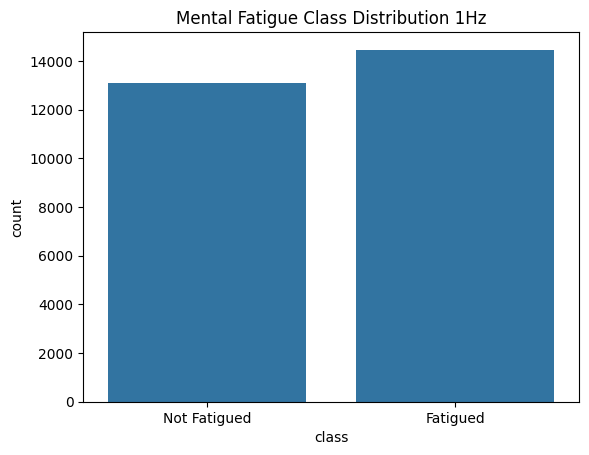

In [ ]:
# Check if the data is balanced at 1Hz:
sns.countplot(data=MEFAR_DOWN, x='class')
plt.title("Mental Fatigue Class Distribution 1Hz")
plt.xticks([0,1],['Not Fatigued', 'Fatigued'])
plt.show()

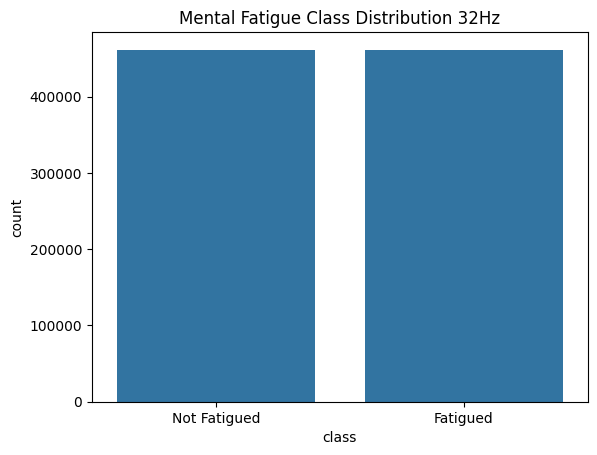

In [24]:
# Check if the data is balanced at 32Hz:
sns.countplot(data=MEFAR_MID, x='class')
plt.title("Mental Fatigue Class Distribution 32Hz")
plt.xticks([0,1],['Not Fatigued', 'Fatigued'])
plt.show()

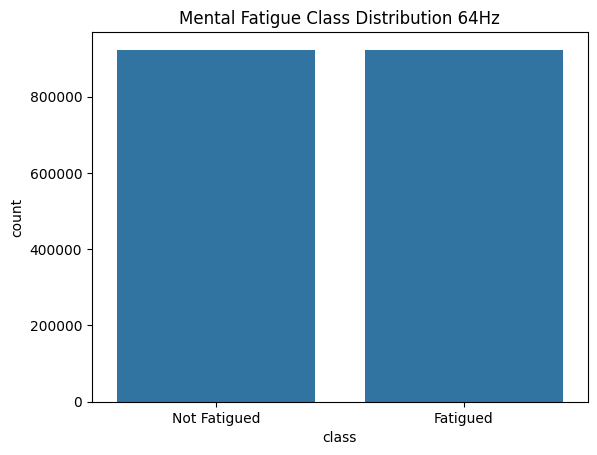

In [25]:
# Check if the data is balanced at 64Hz:
sns.countplot(data=MEFAR_UP, x='class')
plt.title("Mental Fatigue Class Distribution 64Hz")
plt.xticks([0,1],['Not Fatigued', 'Fatigued'])
plt.show()

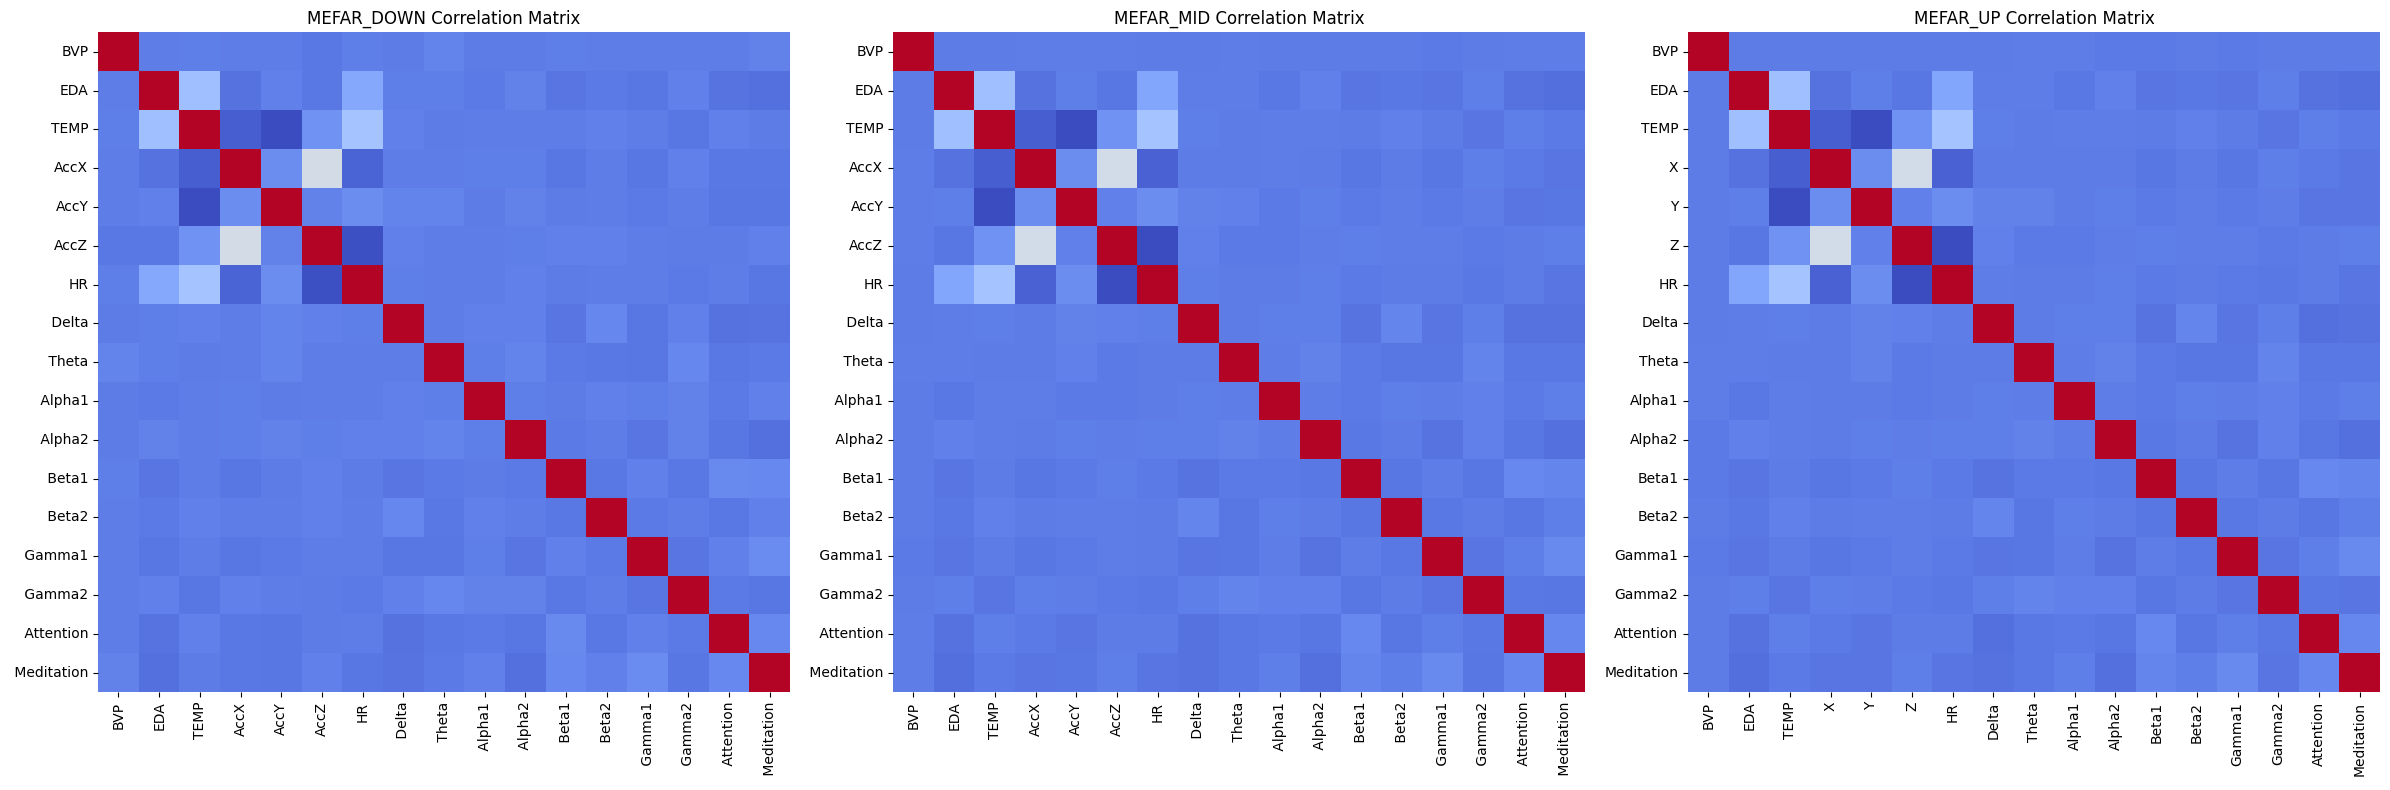

In [27]:

# Set up the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Correlation matrices
corrs = [
    ('MEFAR_DOWN', MEFAR_DOWN.drop(columns=['class']).corr()),
    ('MEFAR_MID', MEFAR_MID.drop(columns=['class']).corr()),
    ('MEFAR_UP', MEFAR_UP.drop(columns=['class']).corr())
]

# Plot each heatmap
for ax, (title, corr) in zip(axes, corrs):
    sns.heatmap(corr, ax=ax, cmap='coolwarm', cbar=False)
    ax.set_title(f"{title} Correlation Matrix")

plt.tight_layout()
plt.show()


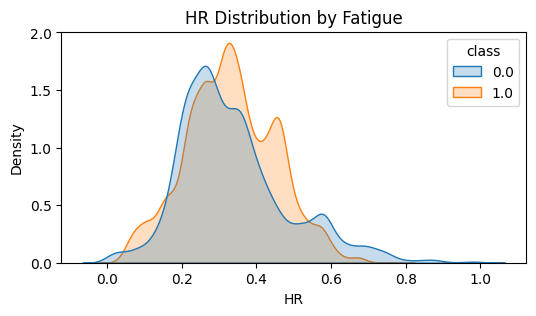

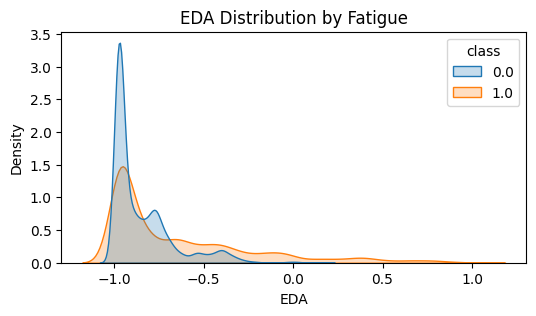

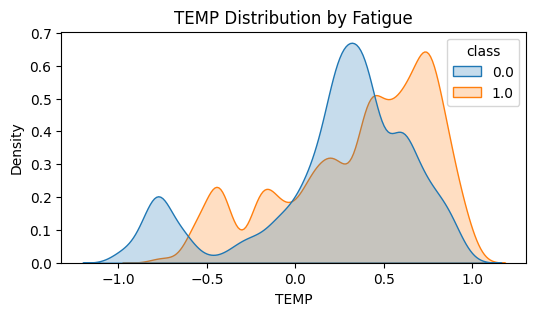

ValueError: Could not interpret value `Attention` for `x`. An entry with this name does not appear in `data`.

<Figure size 600x300 with 0 Axes>

In [28]:
features = ['HR', 'EDA', 'TEMP', 'Attention', 'Meditation']
for feature in features:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=MEFAR_DOWN, x=feature, hue='class', fill=True)
    plt.title(f"{feature} Distribution by Fatigue")
    plt.show()

## 04. Benchmark Models -32Hz:

In [54]:
# Set the X and y variable:
X = MEFAR_MID.drop(columns=['class'])
y = MEFAR_MID['class']


In [ ]:
# Randomly sample 100 000 rows from the MEFAR MID dataset.
X_sample = X.sample(n=100_000,random_state=42)
y_sample = y.loc[X_sample.index]

In [ ]:
# Train/Test Split Sample Set:
X_train, X_test, y_train, y_test = train_test_split(X_sample,y_sample, test_size=0.2,random_state=42)

In [68]:
# Define pipeline for each Model, no preprocess as data already pre-processed.
pipelines = {
    "Logistic Regression": make_pipeline(LogisticRegression(max_iter=1000)),
    "Random Forest": make_pipeline(RandomForestClassifier(n_estimators=100)),
    "SVM": make_pipeline(SVC()),
    "XGBoost": make_pipeline(xgb.XGBClassifier(eval_metric='logloss')),
}

In [69]:
# Cross-Validation Scores
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")

Logistic Regression: 0.643 ± 0.005
Random Forest: 0.995 ± 0.000
SVM: 0.791 ± 0.002
XGBoost: 0.996 ± 0.001


* **Logistic Regression** - 64%, model accuracy is modest, suggesting the data has complex relationships and a linear model can't fully capture. 
* **Random Forest & XGBoost** - 99% & 96% respectively, ensemble tree-based models suggests it captures the non-linear patterns well. Too Well? _data leakage, class imbalance. 
* **SVM** - 79% Indicates that the data is not linearly seperable, but SVM is capturing structure. 
 

## 05. Deep Learning Models -32Hz:

In [76]:
# 1D Convolutional Neural Network (CNN) for Time Series.
model = models.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(timesteps=10, n_channels=6)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (3926458834.py, line 3)